# **MACHINE LEARNING PARA PREVER QUAIS SÃO OS TEMAS DE MAIOR DIFICULDADE DO USUÁRIO** 🌲 ⚡

## De inicio, como de costume, vamos prosseguir com os imports necessários para nossa aplicação!

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

## Criação dos dados a serem utilizados pela ML

Agora, vamos criar nossos dados ficticios que serão utilizados pela nossa ML! 😃

Em produção, esses dados serão retirados do banco de dados conforme os alunos utilizam a plataforma mobile!

In [ ]:
# Configuração inicial
np.random.seed(42)

# Criar dados simulados para tb_Pergunta
tb_pergunta = pd.DataFrame({
    'id_pergunta': range(1, 1111),
    'tipo_pergunta': np.random.choice(
        ['Fontes de Energia Renovável', 'Transporte Sustentável', 'Impacto Ambiental',
         'Mudanças Climáticas', 'Redução de Consumo Doméstico'], size=1110
    )
})

# Criar dados simulados para tb_Opcao (4 opções por pergunta)
tb_opcao = pd.DataFrame({
    'id_opcao': range(1, len(tb_pergunta) * 4 + 1),  # 4 opções para cada pergunta
    'id_pergunta': np.repeat(tb_pergunta['id_pergunta'], 4),
    'texto': np.random.choice([1, 2, 3, 4], size=len(tb_pergunta) * 4),
    'op_correta': np.random.choice(['N', 'S'], size=len(tb_pergunta) * 4, p=[0.7, 0.3])  # 70% N, 30% S
})

# Criar dados simulados para tb_Resposta
tb_resposta = pd.DataFrame({
    'id_resposta': range(1, 3001),  # 3.000 respostas no total
    'id_usuario': np.random.choice(range(1, 6), size=3000),
    'id_pergunta': np.random.choice(tb_pergunta['id_pergunta'], size=3000),
    'op_escolhida': np.random.choice(tb_opcao['id_opcao'], size=3000),
    'tempo_resposta': np.random.uniform(5, 30, size=3000),  # Tempo de resposta em segundos
    'mudanca_resposta': np.random.choice([0, 1], size=3000, p=[0.8, 0.2])  # Simula mudanças de resposta
})

## Pré-processamento

Seguiremos com o Pré-processamento dos dados, de início, iremos juntar as tabelas para podermos ter todas as info de cada resposta dada pelo aluno! Em seguida, faremos os cálculos como média, soma e porcentagens a fim de que cada variável seja melhor compreendida/analisada pelo nosso modelo!

In [ ]:
# Mesclar tabelas para verificar as respostas corretas e incorretas
df = pd.merge(tb_resposta, tb_opcao, left_on=['id_pergunta', 'op_escolhida'],
                     right_on=['id_pergunta', 'id_opcao'], how='inner')
df = pd.merge(df, tb_pergunta, on='id_pergunta', how='inner')


In [ ]:
# O cálculo de acertos e erros é feito diretamente com base em 'op_correta'
df_stats = df.groupby(['id_usuario', 'tipo_pergunta']).agg(
    total_respostas=('id_resposta', 'size'),
    acertos=('op_correta', lambda x: (x == 'S').sum()),
    erros=('op_correta', lambda x: (x == 'N').sum()),
    tempo_medio=('tempo_resposta', 'mean'),
    tempo_desvio=('tempo_resposta', 'std'),
    mudancas_resposta=('mudanca_resposta', 'sum'),
).reset_index()

# Adicionar a proporção de acertos e erros
df_stats['proporcao_acertos'] = (df_stats['acertos'] / df_stats['total_respostas']) * 100
df_stats['porcentagem_erros'] = (df_stats['erros'] / df_stats['total_respostas']) * 100

# Criar variável-alvo: Dificuldade (baseada majoritariamente em proporção de acertos < 80%)
df_stats['dificuldade'] = (df_stats['proporcao_acertos'] < 80).astype(int)

In [ ]:
# Adicionar exemplos manualmente para ambas as classes
extra_data = pd.DataFrame({
    'id_usuario': [6, 6, 6, 7, 7],
    'tipo_pergunta': ['Fontes de Energia Renovável', 'Transporte Sustentável',
                      'Impacto Ambiental', 'Mudanças Climáticas', 'Redução de Consumo Doméstico'],
    'total_respostas': [10, 15, 20, 25, 30],
    'tempo_medio': [12, 15, 10, 20, 18],
    'tempo_desvio': [2, 3, 4, 6, 5],
    'mudancas_resposta': [1, 2, 3, 1, 0],
    'proporcao_acertos': [85, 70, 65, 90, 95],  # Algumas altas, algumas baixas
    'porcentagem_erros': [15, 30, 35, 10, 5],
    'dificuldade': [0, 1, 1, 0, 0]  # Ambas as classes
})
df_stats = pd.concat([df_stats, extra_data], ignore_index=True)

# Preencher valores NaN em tempo_desvio
df_stats['tempo_desvio'] = df_stats['tempo_desvio'].fillna(0)

## Treinamento e avaliação do modelo

Temos um problema muito comum em ML que acabou ocorrendo ao longo do desenvolvimento, chamado **desequilíbrio de classes**. Para isso, vamos abordar uma técnica chamada SMOTE, que o nome bonito é: *"Synthetic Minority Over-sampling Technique"*

Mas em resumo, isso acontece quando uma classe **(no nosso caso, se um tópico é difícil ou não)** tem significativamente mais amostras do que a outra. Isso pode levar a um modelo que é **enviesado** em relação à classe majoritária. O SMOTE visa combater isso, retornando os dados reamostrados, que agora têm uma representação mais equilibrada de ambas as classes por meio de amostras sintéticas da classe minoritária  (legal né? 😉)

Em seguida, dividiremos e treinaremos o nosso modelo como já é de costume também!

In [ ]:
# Balancear classes usando SMOTE
X = df_stats[['total_respostas', 'tempo_medio', 'tempo_desvio', 'mudancas_resposta',
              'proporcao_acertos', 'porcentagem_erros']]
y = df_stats['dificuldade']
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Treinar modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Avaliar modelo
print("\n---------------------------------------------------------------------")
y_pred = rf_model.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print(f"Acurácia do modelo: {accuracy_score(y_test, y_pred):.2f}\n")
print("---------------------------------------------------------------------\n")


---------------------------------------------------------------------
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Acurácia do modelo: 1.00

---------------------------------------------------------------------



Antes de testar com um conjunto de dados, vamos verificar o quanto o modelo determina cada variável durante sua predição!

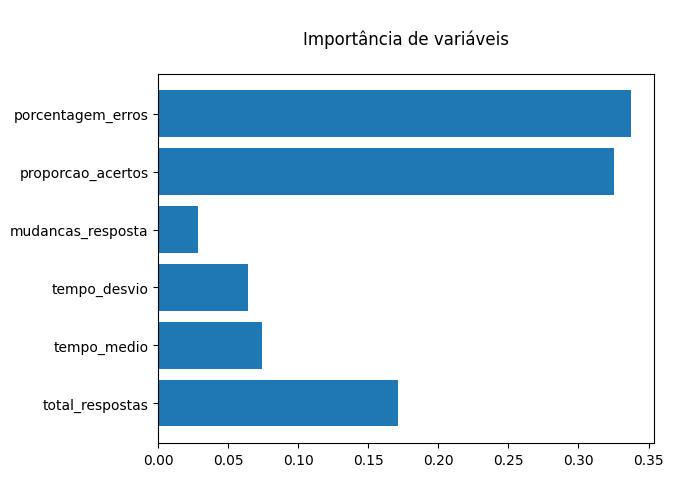

In [ ]:
# Exibindo o quanto cada variável é importante para o modelo
feature_importances = rf_model.feature_importances_
features = X.columns
plt.barh(features, feature_importances)
plt.title("\nImportância de variáveis\n")
plt.show()

## Teste de predição

**AGORA SIM!!!** Podemos seguir e criar um df englobando todos os temas para que nosso modelo possa determinar os riscos (altos ou baixos) para cada aluno de nossa plataforma! 😃😃😃

In [ ]:
# Criar um DataFrame com os temas para previsão
novos_dados_usuario = pd.DataFrame({
    'tipo_pergunta': ['Fontes de Energia Renovável', 'Transporte Sustentável', 'Impacto Ambiental',
                      'Mudanças Climáticas', 'Redução de Consumo Doméstico'],
    'total_respostas': [50, 45, 40, 60, 55],
    'tempo_medio': [12, 15, 10, 20, 18],
    'tempo_desvio': [2, 3, 4, 6, 5],
    'mudancas_resposta': [1, 2, 3, 1, 0],
    'proporcao_acertos': [85, 75, 65, 80, 90],
    'porcentagem_erros': [15, 25, 35, 20, 10],
})
print("-------------------------------------------------------------------------------------------------------------------------------------\n")
print("Dados exemplo de um usuário para previsão: \n")
print(novos_dados_usuario.to_string())
print("\n-------------------------------------------------------------------------------------------------------------------------------------")

# Fazer previsões
X_novos = novos_dados_usuario[['total_respostas', 'tempo_medio', 'tempo_desvio',
                                'mudancas_resposta', 'proporcao_acertos', 'porcentagem_erros']]
novos_dados_usuario['dificuldade_predita'] = rf_model.predict(X_novos)

# Exibir previsões para cada tema
for index, row in novos_dados_usuario.iterrows():
    dificuldade = 'alta' if row['dificuldade_predita'] == 1 else 'baixa'
    print(f"\nPrevisão para dificuldade em {row['tipo_pergunta']}: {dificuldade}")

print("\n-------------------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------------------------

Dados exemplo de um usuário para previsão: 

                  tipo_pergunta  total_respostas  tempo_medio  tempo_desvio  mudancas_resposta  proporcao_acertos  porcentagem_erros
0   Fontes de Energia Renovável               50           12             2                  1                 85                 15
1        Transporte Sustentável               45           15             3                  2                 75                 25
2             Impacto Ambiental               40           10             4                  3                 65                 35
3           Mudanças Climáticas               60           20             6                  1                 80                 20
4  Redução de Consumo Doméstico               55           18             5                  0                 90                 10

---------------------

Deu tudo certo! Mas para confirmar de fato, vamos extrapolar nos dados para que o primeiro seja baixo e o segundo alto...

In [ ]:
# Criar um DataFrame com os temas para previsão
novos_dados_usuario = pd.DataFrame({
    'tipo_pergunta': ['Fontes de Energia Renovável', 'Transporte Sustentável'],
    'total_respostas': [1000, 1000],
    'tempo_medio': [5, 38],
    'tempo_desvio': [0, 7],
    'mudancas_resposta': [0, 8],
    'proporcao_acertos': [95, 40],
    'porcentagem_erros': [5, 60],
})
print("-------------------------------------------------------------------------------------------------------------------------------------\n")
print("Dados exemplo de um usuário para previsão: \n")
print(novos_dados_usuario.to_string())
print("\n-------------------------------------------------------------------------------------------------------------------------------------")

# Fazer previsões
X_novos = novos_dados_usuario[['total_respostas', 'tempo_medio', 'tempo_desvio',
                                'mudancas_resposta', 'proporcao_acertos', 'porcentagem_erros']]
novos_dados_usuario['dificuldade_predita'] = rf_model.predict(X_novos)

# Exibir previsões para cada tema
for index, row in novos_dados_usuario.iterrows():
    dificuldade = 'alta' if row['dificuldade_predita'] == 1 else 'baixa'
    print(f"\nPrevisão para dificuldade em {row['tipo_pergunta']}: {dificuldade}")

print("\n-------------------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------------------------

Dados exemplo de um usuário para previsão: 

                 tipo_pergunta  total_respostas  tempo_medio  tempo_desvio  mudancas_resposta  proporcao_acertos  porcentagem_erros
0  Fontes de Energia Renovável             1000            5             0                  0                 95                  5
1       Transporte Sustentável             1000           38             7                  8                 40                 60

-------------------------------------------------------------------------------------------------------------------------------------

Previsão para dificuldade em Fontes de Energia Renovável: baixa

Previsão para dificuldade em Transporte Sustentável: alta

-------------------------------------------------------------------------------------------------------------------------------------


**UHUUULLL!** Com isso, finalizamos por aqui! Agradeço a atenção de todos e até mais! ✌😃 🤝 😊👍

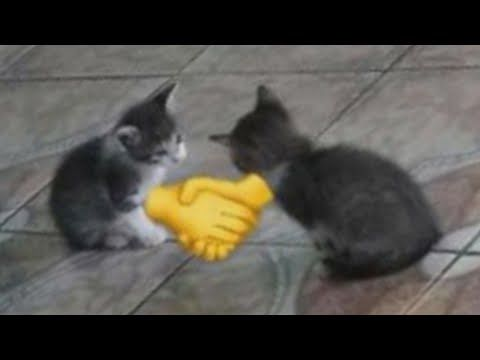